# Simulation Interruptions in cadCAD through overrides

This is an demonstration on how to use an State Variable called `interrupt` in order to control the duration of the simulation by patching the cadCAD engine.

There is a key limitation: When an Simulation is interrupted, all the other simultaneous parameter sweeps will also be interrupted. Only parallel MC runs will continue to execute.

Danilo Lessa Bernardineli (danilo.lessa@gmail.com)

---

## Dependences

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from random import random
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim

## Definitions

### Initial conditions and parameters

In [2]:
initial_conditions = {
    'prey_population': 100,
    'predator_population': 15,
    'interrupt': False
    }

params = {
    "prey_birth_rate": [1.0],
    "predator_birth_rate": [0.01],
    "predator_death_const": [1.0],
    "prey_death_const": [0.03],
    "dt": [0.1] # Precision of the simulation. Lower is more accurate / slower
}

### Policies

In [3]:
def p_predator_births(params, step, sL, s):
  dt = params['dt']
  predator_population = s['predator_population']
  prey_population = s['prey_population']
  birth_fraction = params['predator_birth_rate'] + np.random.random() * 0.0002
  births =  birth_fraction * prey_population * predator_population * dt
  return {'add_to_predator_population': births}


def p_prey_births(params, step, sL, s):
  dt = params['dt']
  population = s['prey_population']
  birth_fraction = params['prey_birth_rate'] + np.random.random() * 0.1
  births =  birth_fraction * population * dt
  return {'add_to_prey_population': births}


def p_predator_deaths(params, step, sL, s):
  dt = params['dt']
  population = s['predator_population']
  death_rate = params['predator_death_const'] + np.random.random() * 0.005
  deaths = death_rate * population * dt
  return {'add_to_predator_population': -1.0 * deaths}


def p_prey_deaths(params, step, sL, s):
  dt = params['dt']
  death_rate = params['prey_death_const'] + np.random.random() * 0.1
  prey_population = s['prey_population']
  predator_population = s['predator_population']
  deaths = death_rate * prey_population * predator_population * dt
  return {'add_to_prey_population': -1.0 * deaths}

### State update functions

In [4]:
def s_prey_population(params, step, sL, s, _input):
    y = 'prey_population'
    x = s['prey_population'] + _input['add_to_prey_population']
    return (y, x)


def s_predator_population(params, step, sL, s, _input):
    y = 'predator_population'
    x = s['predator_population'] + _input['add_to_predator_population']
    return (y, x)

def s_interrupt(params, step, sL, s, _input):
    
    interrupt = False
    if s['timestep'] > 3:
        if random() > 0.8:
            interrupt = True
        else:
            interrupt = False
    return ('interrupt', interrupt)

### State update blocks

In [5]:
partial_state_update_blocks = [
    { 
        'label': 'Lotka-Volterra Dynamics',
        'policies': {
            'predator_births': p_predator_births,
            'prey_births': p_prey_births,
            'predator_deaths': p_predator_deaths,
            'prey_deaths': p_prey_deaths,
        },
        'variables': {
            'predator_population': s_prey_population,
            'prey_population': s_predator_population
        }
    },
    {
        'label': 'Simulation Interruption Logic',
        'policies': {},
        'variables': {
            'prey_population': s_interrupt
        }
        
    }
]

### Patch 1

In [6]:
from typing import Tuple, Any, Dict, List, Callable

from cadCAD.engine.simulation import Executor as SimExecutor

def new_run_pipeline(
        self,
        sweep_dict: Dict[str, List[Any]],
        states_list: List[Dict[str, Any]],
        configs: List[Tuple[List[Callable], List[Callable]]],
        env_processes: Dict[str, Callable],
        time_seq: range,
        run: int,
        additional_objs
    ) -> List[List[Dict[str, Any]]]:
        time_seq: List[int] = [x + 1 for x in time_seq]
        simulation_list: List[List[Dict[str, Any]]] = [states_list]

        for time_step in time_seq:
            pipe_run: List[Dict[str, Any]] = self.state_update_pipeline(
                sweep_dict, simulation_list, configs, env_processes, time_step, run, additional_objs
            )
            _, *pipe_run = pipe_run
            simulation_list.append(pipe_run)
            
            last_run = pipe_run[-1]
            do_stop = last_run.get('interrupt', False)
            if do_stop:
                break

        return simulation_list
    
SimExecutor.run_pipeline = new_run_pipeline

### Patch 2: Make `cadCAD.engine.Executor` use `self.SimExecutor` for simulations rather than `SimExecutor`

In [7]:
from cadCAD.utils import flatten
from cadCAD.utils.execution import print_exec_info
from cadCAD.configuration import Configuration, Processor
from cadCAD.configuration.utils import TensorFieldReport, configs_as_objs, configs_as_dicts
from cadCAD.engine.execution import single_proc_exec, parallelize_simulations, local_simulations


def new_execute(self) -> Tuple[Any, Any, Dict[str, Any]]:
        if self.empty_return is True:
            return [], [], []

        config_proc = Processor()
        create_tensor_field = TensorFieldReport(config_proc).create_tensor_field

        sessions = []
        var_dict_list, states_lists = [], []
        Ts, Ns, SimIDs, RunIDs = [], [], [], []
        ExpIDs, ExpWindows, SubsetIDs, SubsetWindows = [], [], [], []
        eps, configs_structs, env_processes_list = [], [], []
        partial_state_updates, sim_executors = [], []
        config_idx = 0

        # Execution Info
        print_exec_info(self.exec_context, configs_as_objs(self.configs))

        t1 = time()
        for x in self.configs:
            sessions.append(
                {
                    'user_id': x.user_id, 'experiment_id': x.experiment_id, 'session_id': x.session_id,
                    'simulation_id': x.simulation_id, 'run_id': x.run_id,
                    'subset_id': x.subset_id, 'subset_window': x.subset_window
                }
            )
            Ts.append(x.sim_config['T'])
            Ns.append(x.sim_config['N'])

            ExpIDs.append(x.experiment_id)
            ExpWindows.append(x.exp_window)
            SimIDs.append(x.simulation_id)
            SubsetIDs.append(x.subset_id)
            RunIDs.append(x.run_id)
            SubsetWindows.append(x.subset_window)

            var_dict_list.append(x.sim_config['M'])
            states_lists.append([x.initial_state])
            eps.append(list(x.exogenous_states.values()))
            configs_structs.append(config_proc.generate_config(x.initial_state, x.partial_state_update_blocks, eps[config_idx]))
            env_processes_list.append(x.env_processes)
            partial_state_updates.append(x.partial_state_update_blocks)
            sim_executors.append(self.SimExecutor(x.policy_ops).simulation)

            config_idx += 1

        def get_final_dist_results(simulations, psus, eps, sessions):
            tensor_fields = [create_tensor_field(psu, ep) for psu, ep in list(zip(psus, eps))]
            return simulations, tensor_fields, sessions

        def get_final_results(simulations, psus, eps, sessions, remote_threshold):
            flat_timesteps, tensor_fields = [], []
            for sim_result, psu, ep in list(zip(simulations, psus, eps)):
                flat_timesteps.append(flatten(sim_result))
                tensor_fields.append(create_tensor_field(psu, ep))

            flat_simulations = flatten(flat_timesteps)
            if config_amt == 1:
                return simulations, tensor_fields, sessions
            elif config_amt > 1:
                return flat_simulations, tensor_fields, sessions

        remote_threshold = 100
        config_amt = len(self.configs)

        def auto_mode_switcher(config_amt):
            try:
                if config_amt == 1:
                    return ExecutionMode.single_mode, single_proc_exec
                elif (config_amt > 1):
                    return ExecutionMode.multi_mode, parallelize_simulations
            except AttributeError:
                if config_amt < 1:
                    raise ValueError('N must be >= 1!')

        final_result = None
        original_N = len(configs_as_dicts(self.configs))
        if self.exec_context != ExecutionMode.distributed:
            # Consider Legacy Support
            if self.exec_context != ExecutionMode.local_mode:
                self.exec_context, self.exec_method = auto_mode_switcher(config_amt)

            print("Execution Method: " + self.exec_method.__name__)
            simulations_results = self.exec_method(
                sim_executors, var_dict_list, states_lists, configs_structs, env_processes_list, Ts, SimIDs, RunIDs,
                ExpIDs, SubsetIDs, SubsetWindows, original_N
            )

            final_result = get_final_results(simulations_results, partial_state_updates, eps, sessions, remote_threshold)
        elif self.exec_context == ExecutionMode.distributed:
            print("Execution Method: " + self.exec_method.__name__)
            simulations_results = self.exec_method(
                sim_executors, var_dict_list, states_lists, configs_structs, env_processes_list, Ts,
                SimIDs, RunIDs, ExpIDs, SubsetIDs, SubsetWindows, original_N, self.sc
            )
            final_result = get_final_dist_results(simulations_results, partial_state_updates, eps, sessions)

        t2 = time()
        print(f"Total execution time: {t2 - t1 :.2f}s")

        return final_result
    
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

Executor.SimExecutor = SimExecutor
Executor.execute = new_execute

### Configuration and Execution

In [8]:
from time import time
def run(N, T):
  t1 = time()
  simulation_parameters = {
      'N': N,
      'T': range(T),
      'M': params
  }
  sim_config = config_sim(simulation_parameters)

  exp = Experiment()
  exp.append_configs(sim_configs=sim_config, 
                    initial_state=initial_conditions,
                    partial_state_update_blocks=partial_state_update_blocks)


  exec_mode = ExecutionMode()
  exec_context = ExecutionContext(exec_mode.local_mode)
  executor = Executor(exec_context=exec_context, 
                      configs=exp.configs)
  
  (records, tensor_field, _) = executor.execute() 
  t2 = time()
  print(t2 - t1)
  return pd.DataFrame(records)
df = run(3, 50)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 50, 5, 3, 3)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (50, 5, 3, 3)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 0.19s
0.19359326362609863


In [16]:
df

,prey_population,predator_population,interrupt,simulation,subset,run,substep,timestep
0,100.000000,15.000000,False,0,0,1,0,0
1,98.079167,15.003262,False,0,0,1,1,1
2,98.079167,15.003262,False,0,0,1,2,1
3,103.804918,14.988498,False,0,0,1,1,2
4,103.804918,14.988498,False,0,0,1,2,2
5,96.876525,15.047562,False,0,0,1,1,3
6,96.876525,15.047562,False,0,0,1,2,3
7,94.693976,15.018624,False,0,0,1,1,4
8,94.693976,15.018624,True,0,0,1,2,4
9,100.000000,15.000000,False,0,0,2,0,0


<AxesSubplot: xlabel='run', ylabel='timestep'>

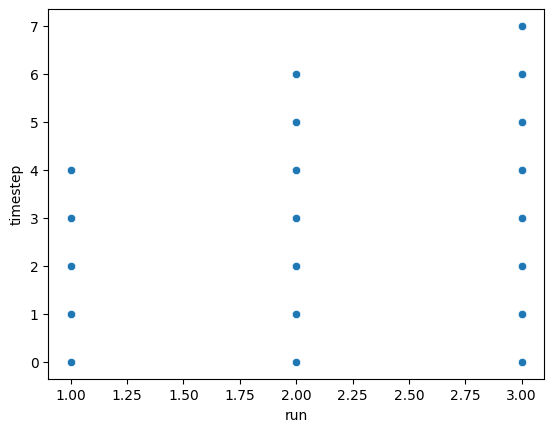

In [14]:
sns.scatterplot(df, y='timestep', x='run')